<a href="https://colab.research.google.com/github/rishabhm4/Densenet---Keras/blob/master/Densenet_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

In [0]:

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
#from keras.preprocessing.image import ImageDataGenerator

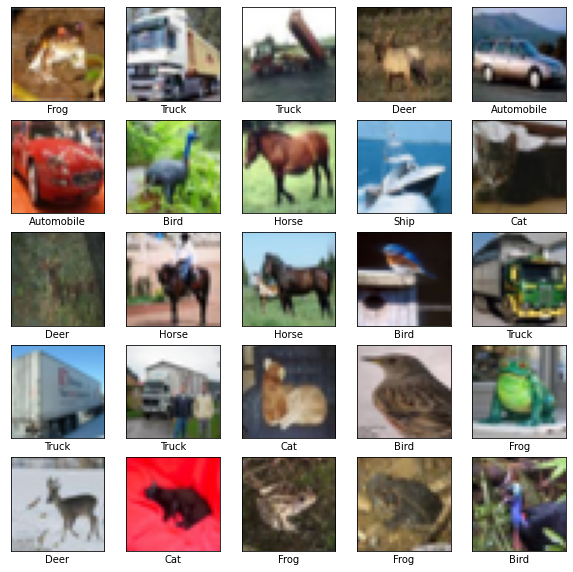

In [0]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
data = tf.data.Dataset.from_tensor_slices(
    (train_images.reshape([-1, 32,32,3]).astype(np.float32) / 255, train_labels.astype(np.int32)))
data = data.shuffle(buffer_size=40000).batch(128).repeat()



### Plotting the first 25 training image from the dataset. 

* This set is a collection of heterogeneous 10 classes. 
* The dataset contain RGB images and they are of share 32*32. Along with a depth of 3.
* Images belong to following classes -> "Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"

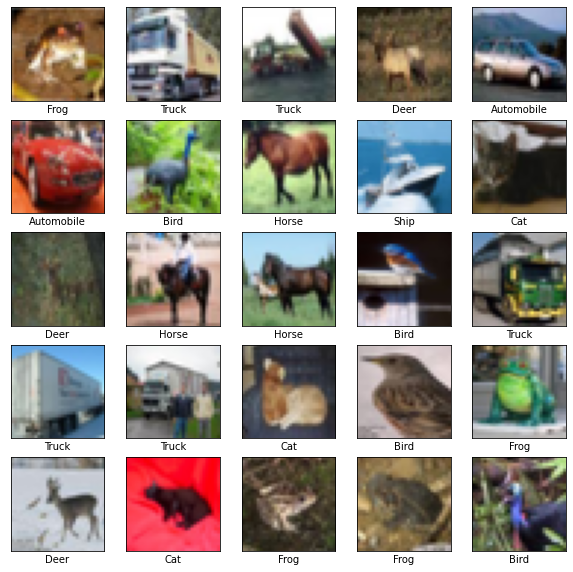

In [0]:
classes = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(classes[int(train_labels[i])])
plt.show()

## DenseNet Architecture 

- The Architecture is not exactly same to the paper but we tried to achieve a similar workflow.
- Consist of 2 Dense Blocks where both having each 4 convolution layers.
- We have not used bottleneck approach but applied batch normalization. 
- The growth rate of our model is 64.

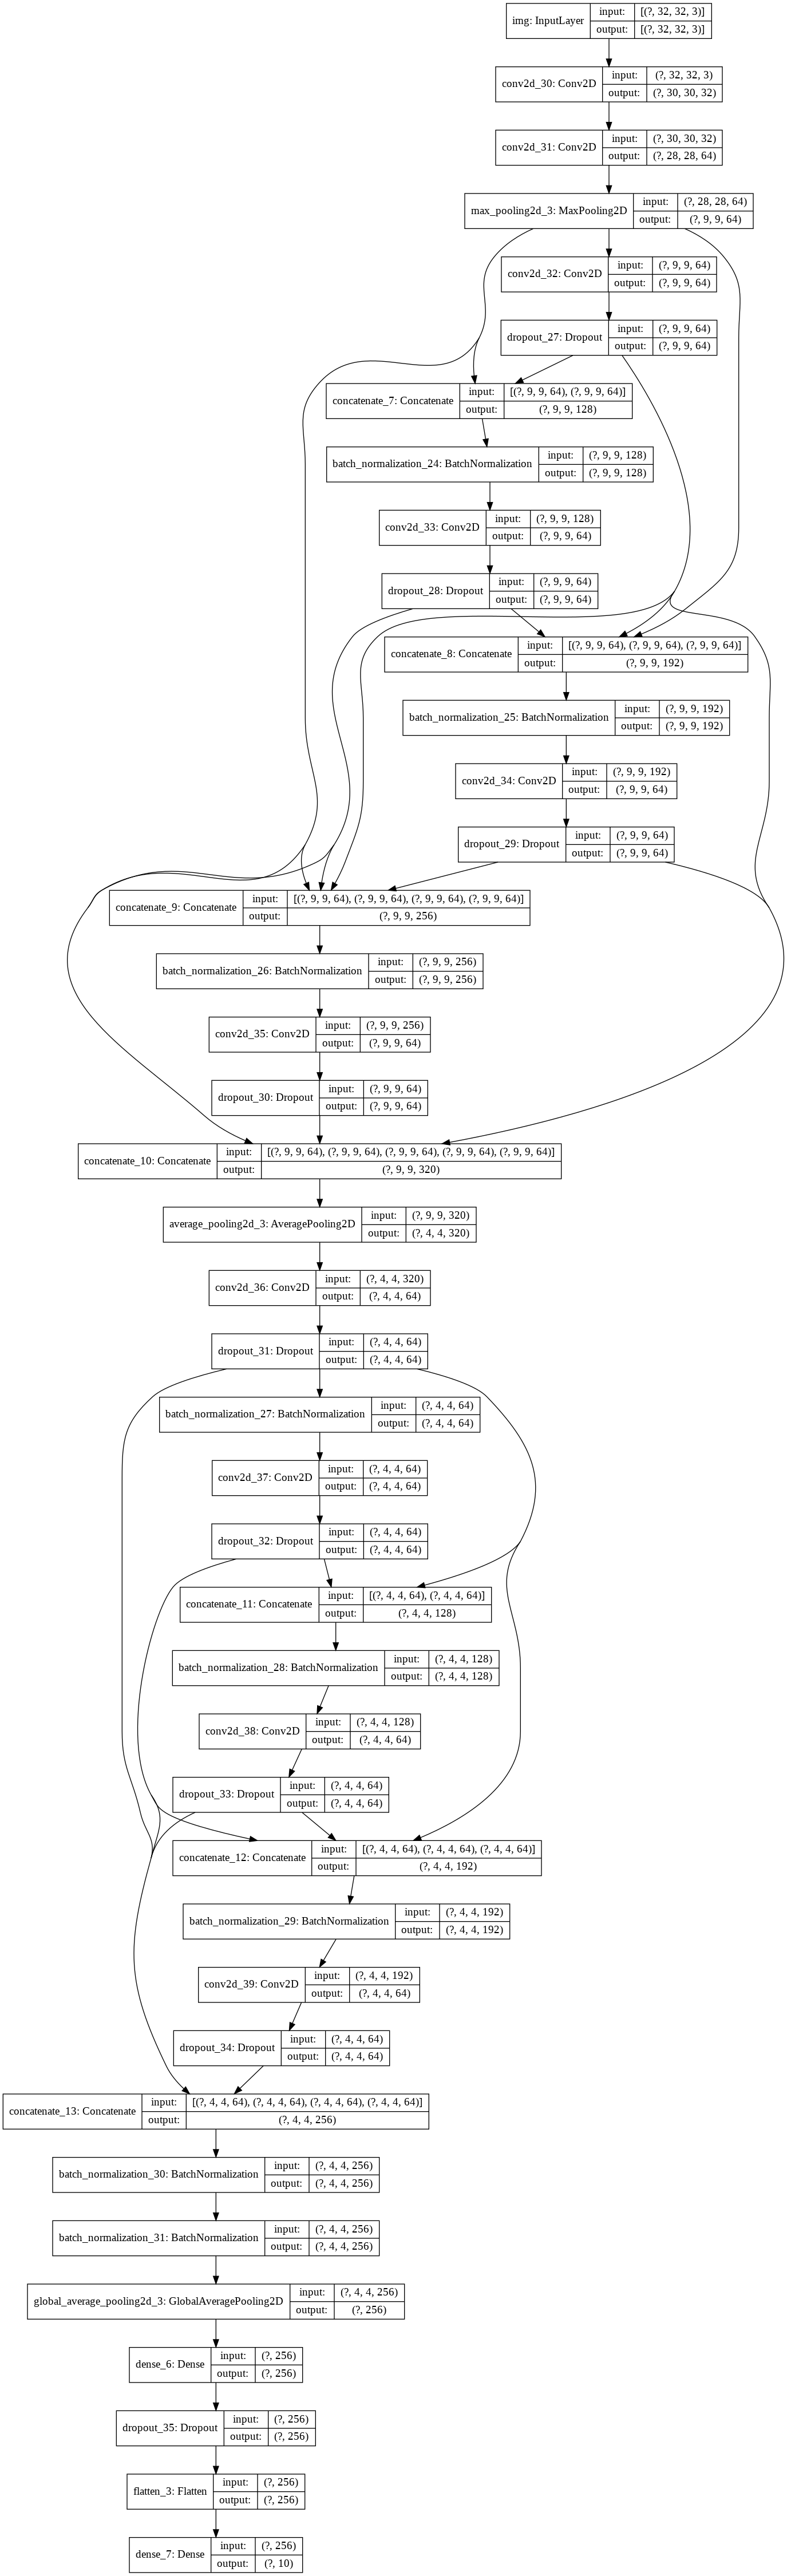

In [0]:
inputs = keras.Input(shape=(32, 32, 3), name='img')
x = layers.Conv2D(32, 3, activation='relu')(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

##Dense Block1##################################################################
x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_1_output)
x = layers.Dropout(0.2)(x)
block1=x
block_2_output = tf.keras.layers.concatenate([block1, block_1_output])
block_2_output =  tf.keras.layers.BatchNormalization()(block_2_output)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Activation('relu')(x)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_2_output)
x = layers.Dropout(0.2)(x)
block2=x
block_3_output = tf.keras.layers.concatenate([block2, block_1_output,block1])
block_3_output =  tf.keras.layers.BatchNormalization()(block_3_output)

x= layers.Conv2D(64, 3, activation='relu', padding='same')(block_3_output)
x = layers.Dropout(0.2)(x)
block3=x
block_4_output = tf.keras.layers.concatenate([x, block_1_output,block1,block2])
block_4_output =  tf.keras.layers.BatchNormalization()(block_4_output)

x= layers.Conv2D(64, 3, activation='relu', padding='same')(block_4_output)
x = layers.Dropout(0.2)(x)
block4=x
block_5_output = tf.keras.layers.concatenate([x, block_1_output,block1,block2,block3])
#############################Transition layer###################################

#block_4_output = layers.add([x, block_1_output,block_2_output,block_3_output])
#x = layers.MaxPooling2D(3)(x)
x = tf.keras.layers.AveragePooling2D(
    pool_size=(2, 2), strides=2)(block_5_output)

## Dense block2 ################################################################
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.Dropout(0.2)(x)
block11=x
#block_12_output = layers.add([block11, block_12_output])
block_11_output =  tf.keras.layers.BatchNormalization()(x)



x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_11_output)
x = layers.Dropout(0.2)(x)
block12=x
block_12_output = tf.keras.layers.concatenate([x, block11])
block_12_output =  tf.keras.layers.BatchNormalization()(block_12_output)


x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_12_output)
x = layers.Dropout(0.2)(x)
block13=x
block_13_output = tf.keras.layers.concatenate([x, block11,block12])
block_13_output =  tf.keras.layers.BatchNormalization()(block_13_output)

x = layers.Conv2D(64, 3, activation='relu', padding='same')(block_13_output)
x = layers.Dropout(0.2)(x)
#block14=x
block_14_output = tf.keras.layers.concatenate([x, block11,block12,block13])
block_14_output =  tf.keras.layers.BatchNormalization()(block_14_output)

################################################################################



x = tf.keras.layers.BatchNormalization()(block_14_output)
x = layers.GlobalAveragePooling2D()(x)

#x = layers.Conv2D(64, 3, activation='relu')(x)
#x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
flat = tf.keras.layers.Flatten()(x)
outputs = layers.Dense(10)(flat)

opt = tf.optimizers.Adam()
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

model = keras.Model(inputs, outputs, name='densenet')
keras.utils.plot_model(model, 'mini_densenet.png', show_shapes=True)

In [0]:
model.summary()

Model: "densenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 30, 30, 32)   896         img[0][0]                        
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 28, 28, 64)   18496       conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 9, 9, 64)     0           conv2d_31[0][0]                  
___________________________________________________________________________________________

In [0]:

train_acc_metric = tf.metrics.SparseCategoricalAccuracy()

## Using Graph execution
#### (cookie task)

In [0]:
# stereotypical train-step-with-function-annotation
train_steps = 1500
@tf.function
def train_step(imgs, lbls):
    with tf.GradientTape() as tape:
        logits = model(imgs)
        xent = loss_fn(lbls, logits)

    varis = model.trainable_variables
    grads = tape.gradient(xent, varis)
    opt.apply_gradients(zip(grads, varis))

    return xent, logits

In [0]:
start = time.time()
for step, (img_batch, lbl_batch) in enumerate(data):
    if step > train_steps:
        break

    xent, logits = train_step(img_batch, lbl_batch)

    if not step % 100:
        train_acc_metric(lbl_batch, logits)
        acc = train_acc_metric.result()
        print("Loss: {} Accuracy: {}".format(xent, acc))
        train_acc_metric.reset_states()

        stop = time.time()
        print("took {} seconds\n".format(stop-start))
        start = time.time()

Loss: 2.30465030670166 Accuracy: 0.0859375
took 3.3446667194366455 seconds

Loss: 1.8513437509536743 Accuracy: 0.265625
took 115.06113266944885 seconds

Loss: 1.6771230697631836 Accuracy: 0.4140625
took 115.56995582580566 seconds

Loss: 1.3399004936218262 Accuracy: 0.4609375
took 117.02670240402222 seconds

Loss: 1.2174509763717651 Accuracy: 0.515625
took 115.67143893241882 seconds

Loss: 1.3097929954528809 Accuracy: 0.53125
took 115.84046840667725 seconds

Loss: 1.1328307390213013 Accuracy: 0.5546875
took 116.46146440505981 seconds

Loss: 1.093965768814087 Accuracy: 0.59375
took 115.88797330856323 seconds

Loss: 0.8930380940437317 Accuracy: 0.6953125
took 115.77815103530884 seconds

Loss: 0.9881355166435242 Accuracy: 0.65625
took 117.58315658569336 seconds

Loss: 0.918989896774292 Accuracy: 0.671875
took 118.33368849754333 seconds

Loss: 0.8033802509307861 Accuracy: 0.75
took 117.81390714645386 seconds

Loss: 0.8076136112213135 Accuracy: 0.7578125
took 117.07956337928772 seconds

Loss

In [0]:
test_data = tf.data.Dataset.from_tensor_slices(
    (test_images.reshape([-1, 32,32,3]).astype(np.float32) / 255, test_labels.astype(np.int32))).batch(128)

test_acc_metric = tf.metrics.SparseCategoricalAccuracy()
for img_batch, lbl_batch in test_data:
    test_acc_metric(lbl_batch, model(img_batch))

test_acc_metric.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.7292>

## Oberservations
- The train/test accuracy on CIFAR100 = 52%/42%
- The computation time with graph execution is a bit faster but it took 30 min to run the Densenet on CIFAR10.
- With 1 dense block our train/test accuracy with CIFAR10 was around 85%/79%.